# EMNIST Image Generation GAN

Name: Rejey Ezekiel<br/><br/>
Admin Number: P2348935<br/><br/>

Name: Ng Qing Yang<br/><br/>
Admin Number: ______<br/><br/>

Class: DAAA/FT/2A/01<br/><br/>
Module Code: ST1504 Deep Learning<br/>

<hr>

<h3>References (In Harvard format):</h3>
<ol>

</ol>


# Initialising Libraries and Variables

In [7]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras import Sequential, Model
from keras.layers import Embedding, Concatenate, Dense,ZeroPadding2D, Conv2D, Reshape,BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten, Conv2DTranspose, UpSampling2D
import plotly as px
from scipy.ndimage import rotate, shift
from numpy.random import randn
from numpy.random import randint
from collections import Counter

In [8]:
# List physical GPUs and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

# Loading Datasets


In [9]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('emnist-letters-train.csv', delimiter=',', header=None)
df

   ---------------------------------------- 0.0/17.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/17.3 MB 7.9 MB/s eta 0:00:03
   ---- ----------------------------------- 2.0/17.3 MB 18.3 MB/s eta 0:00:01
   ---------- ----------------------------- 4.7/17.3 MB 30.2 MB/s eta 0:00:01
   ---------------- ----------------------- 7.3/17.3 MB 36.1 MB/s eta 0:00:01
   ----------------------- ---------------- 10.1/17.3 MB 40.6 MB/s eta 0:00:01
   -------------------------- ------------- 11.5/17.3 MB 59.5 MB/s eta 0:00:01
   -------------------------- ------------- 11.5/17.3 MB 59.5 MB/s eta 0:00:01
   -------------------------- ------------- 11.5/17.3 MB 59.5 MB/s eta 0:00:01
   ---------------------------------- ----- 14.8/17.3 MB 36.4 MB/s eta 0:00:01
   ---------------------------------------  17.3/17.3 MB 38.5 MB/s eta 0:00:01
   ---------------------------------------- 17.3/17.3 MB 36.4 MB/s eta 0:00

0    1    2    3    4    5    6    7    8    9    ...  775  776  777  \
0       23    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1        7    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2       16    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3       15    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4       23    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99035   18    0    0    0    0    0    0    0    0    0  ...    0    0    0   
99036   24    0    0    0    0    0    0    0    0    0  ...    0    0    0   
99037   19    0    0    0    0    0    0    0    0    0  ...    0    0    0   
99038   -1  174  174  174  174  174  174  174  174  174  ...  174  174  174   
99039   -1   42   42   42   42   42   42   42   42   42  ...   42   42   42   

       778  779  780  781  782  783  784  
0        0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
99035    0    0    0    0    0    0    0  
99036    0    0    0    0    0    0    0  
99037    0    0    0    0    0    0    0  
99038  174  174  174  174  174  174  174  
99039   42   42   42   42   42   42   42  

[99040 rows x 785 columns]

# Exploratory Data Analysis

We will begin by conducting an exploratory data analysis of the data, to gain a better understanding of the characteristics of the dataset.

-   The First columns is the Labels since they are alphabetical there should only be 26 but in this case the count is from -1 to 26 (min - max), therefore there is a extra class which i will be labeling ?.

- There are 784 Columns in the dataset that makes up the Image.

In [10]:
df.describe()

0             1             2             3             4    \
count  99040.000000  99040.000000  99040.000000  99040.000000  99040.000000   
mean      12.018084     13.182553     13.182553     13.182553     13.182563   
std        8.367573     45.515594     45.515594     45.515594     45.515592   
min       -1.000000      0.000000      0.000000      0.000000      0.000000   
25%        5.000000      0.000000      0.000000      0.000000      0.000000   
50%       12.000000      0.000000      0.000000      0.000000      0.000000   
75%       19.000000      0.000000      0.000000      0.000000      0.000000   
max       26.000000    255.000000    255.000000    255.000000    255.000000   

                5             6             7             8             9    \
count  99040.000000  99040.000000  99040.000000  99040.000000  99040.000000   
mean      13.186127     13.197577     13.204645     13.201817     13.197920   
std       45.517474     45.534832     45.545344     45.542036     45.536994   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

       ...           775           776           777           778  \
count  ...  99040.000000  99040.000000  99040.000000  99040.000000   
mean   ...     13.182553     13.182553     13.182553     13.185279   
std    ...     45.515594     45.515594     45.515594     45.521483   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...    255.000000    255.000000    255.000000    255.000000   

                779           780           781           782           783  \
count  99040.000000  99040.000000  99040.000000  99040.000000  99040.000000   
mean      13.182876     13.182553     13.182553     13.182553     13.182553   
std       45.515614     45.515594     45.515594     45.515594     45.515594   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

                784  
count  99040.000000  
mean      13.182553  
std       45.515594  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      255.000000  

[8 rows x 785 columns]

In [11]:
df[0].unique()

array([23,  7, 16, 15, 17, 13, 11, 22, 24, 10, 14, 18, 21, 26, 19,  5, -1,
        3, 25,  2,  8,  4, 20,  9,  6, 12,  1], dtype=int64)

-   The Classes are almsot equal but the -1 class has 10240k images whereas classes 1-26 have roughly 3.4k with a little discrepancies.

In [12]:
import plotly.graph_objects as go

# Count the occurrences of each unique value in the df[0] column
value_counts = df[0].value_counts()
fig = go.Figure(data=[go.Bar(x=value_counts.index, y=value_counts.values)])
fig.update_layout(title='Number of Images in each Class',
                  xaxis_title='Unique Values',
                  yaxis_title='Count',
                  template='plotly_dark',
                  title_x=0.5)  
fig.update_xaxes(tickmode='array', tickvals=value_counts.index)
fig.show()

In [13]:
df[0].value_counts()

0
-1     10240
 25     3453
 11     3438
 5      3437
 24     3437
 20     3436
 17     3435
 16     3430
 9      3428
 26     3427
 8      3424
 23     3423
 22     3422
 21     3419
 18     3419
 3      3419
 12     3415
 15     3408
 10     3402
 13     3402
 4      3398
 2      3396
 1      3396
 6      3394
 19     3392
 7      3385
 14     3365
Name: count, dtype: int64

# Viewing the Images
-   We can see that the images Oreintation is wrong in the case belo we can see that G and H is not in the correct orientation and if left like this the GAN generation will also produce results like this, thus in Preprocessing will need to be done.

-   We can see that the images values range from 0 to 255.

In [14]:
print(df.iloc[0,1:].min())
print(df.iloc[0,1:].max())

0
255


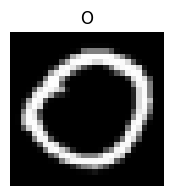

In [15]:
# plotting a random image from the dataset
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(df))
img = np.array(df.iloc[idx, 1:]).reshape(28, 28)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(chr(df[0][idx] + 64))
plt.show()

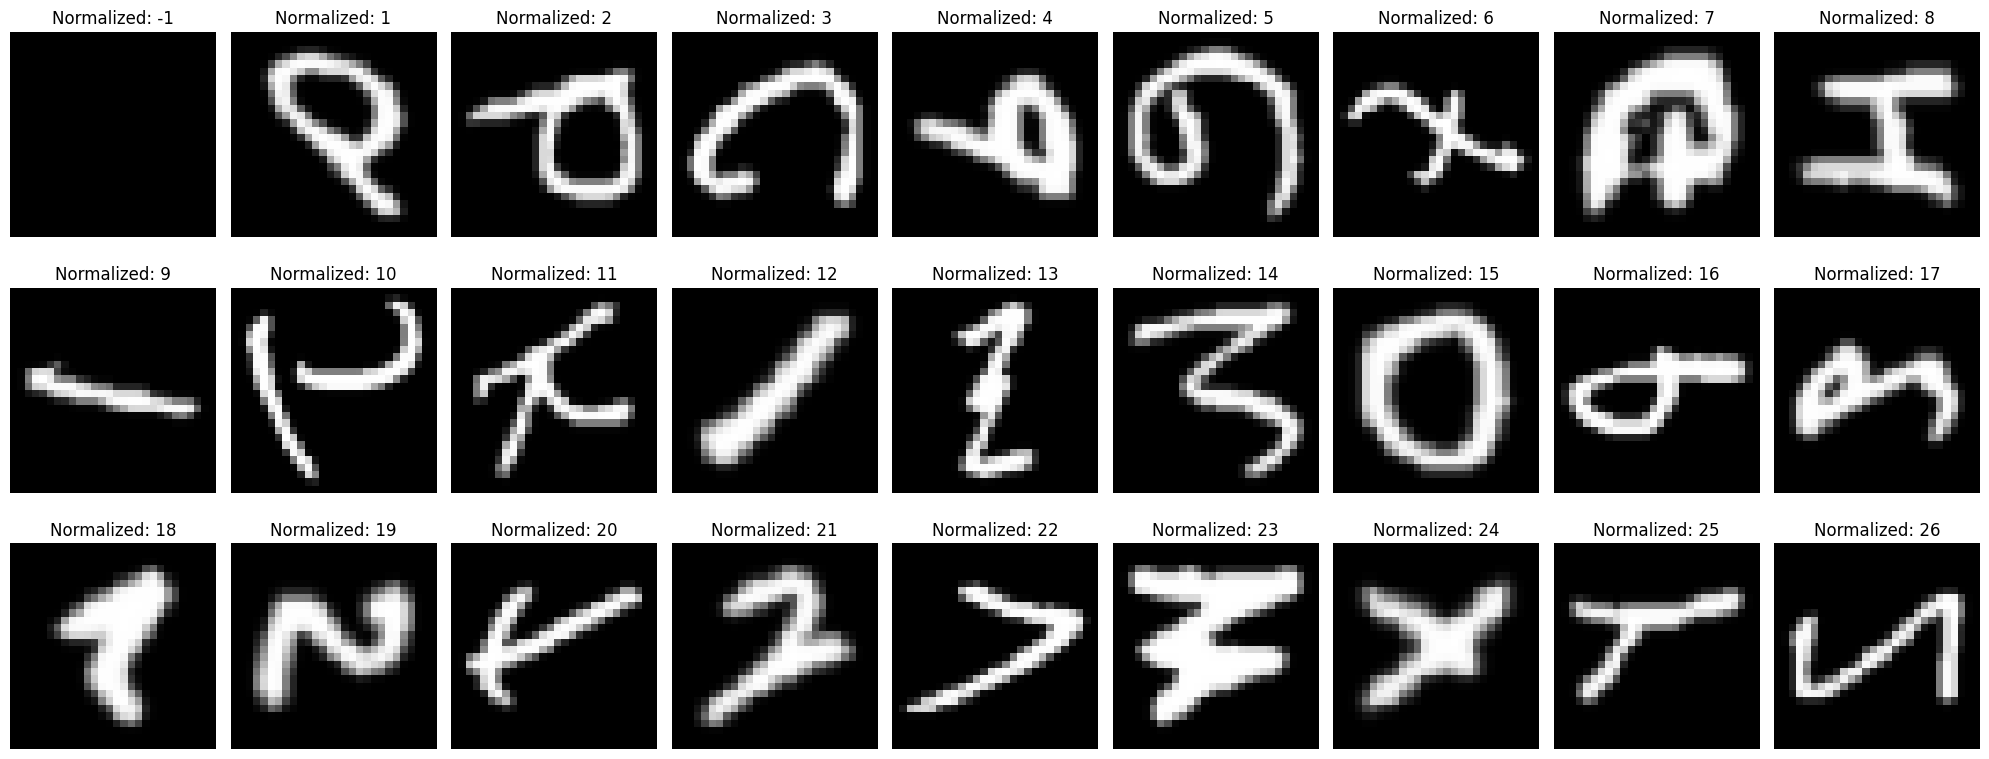

In [16]:
# Get unique labels (assuming you want the first 26 unique labels)
labels = df.iloc[:, 0].unique()
labels = np.sort(labels)

# Create the plot with sufficient subplots
fig, axes = plt.subplots(3, 9, figsize=(20, 8))  # Adjusted to 3 rows and 9 columns for demonstration
axes = axes.flatten()

for label, ax in zip(labels, axes):
    # Select the first row for each unique label
    image_data = df[df.iloc[:, 0] == label].iloc[0, 1:].values
    
    # Ensure the data is in numeric format
    image_data = np.array(image_data, dtype=np.float32)
    
    # Reshape the flat array into a 28x28 image
    image = image_data.reshape(28, 28)
    
    # Display the image
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Normalized: {label}')
    ax.axis('off')

# Hide any remaining empty subplots (if any)
for ax in axes[len(labels):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

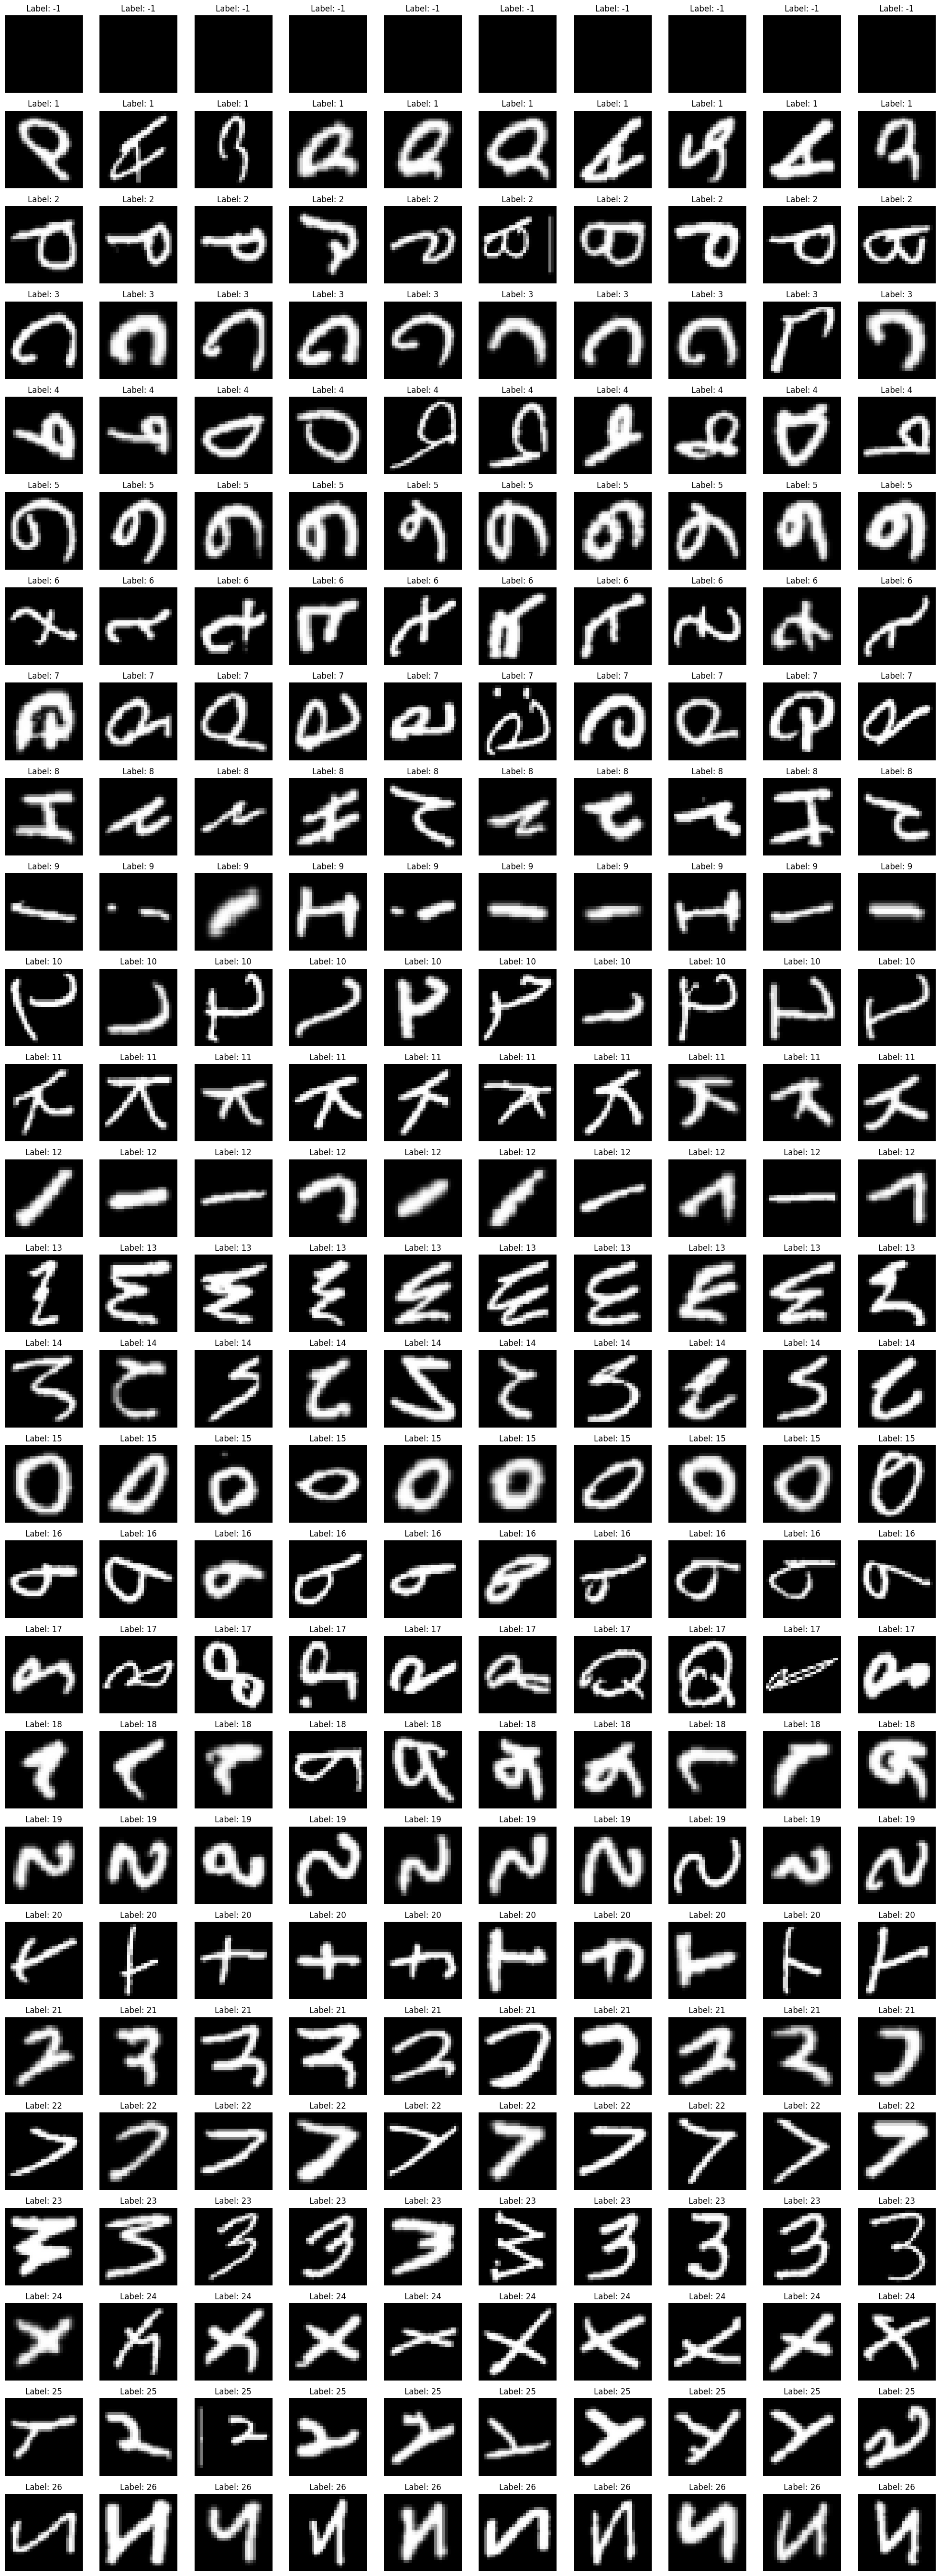

In [17]:
labels = df.iloc[:, 0].unique()
labels = np.sort(labels)

# Determine the total number of subplots required (10 images for each unique label)
num_labels = len(labels)
total_images = num_labels * 10

# Determine the grid size for subplots
grid_cols = 10  # 10 images per row for each label
grid_rows = num_labels  # One row for each label

# Create the plot with sufficient subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, num_labels * 2))
axes = axes.flatten()

# Counter to keep track of the subplot index
subplot_index = 0

for label in labels:
    # Get the first 10 images for the current label
    images_data = df[df.iloc[:, 0] == label].iloc[:10, 1:].values
    
    for image_data in images_data:
        # Ensure the data is in numeric format
        image_data = np.array(image_data, dtype=np.float32)
        
        # Reshape the flat array into a 28x28 image
        image = image_data.reshape(28, 28)
        
        # Display the image
        ax = axes[subplot_index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
        
        # Move to the next subplot
        subplot_index += 1

# Hide any remaining empty subplots (if any)
for ax in axes[subplot_index:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# Image Averageing

-   Image Averaging involves stacking multiple photos on top of each other and averaging them together. The main purpose is to see the noise of the image adn therefore reducing it.
-   We can see the rough shapes of the Alpahbets.

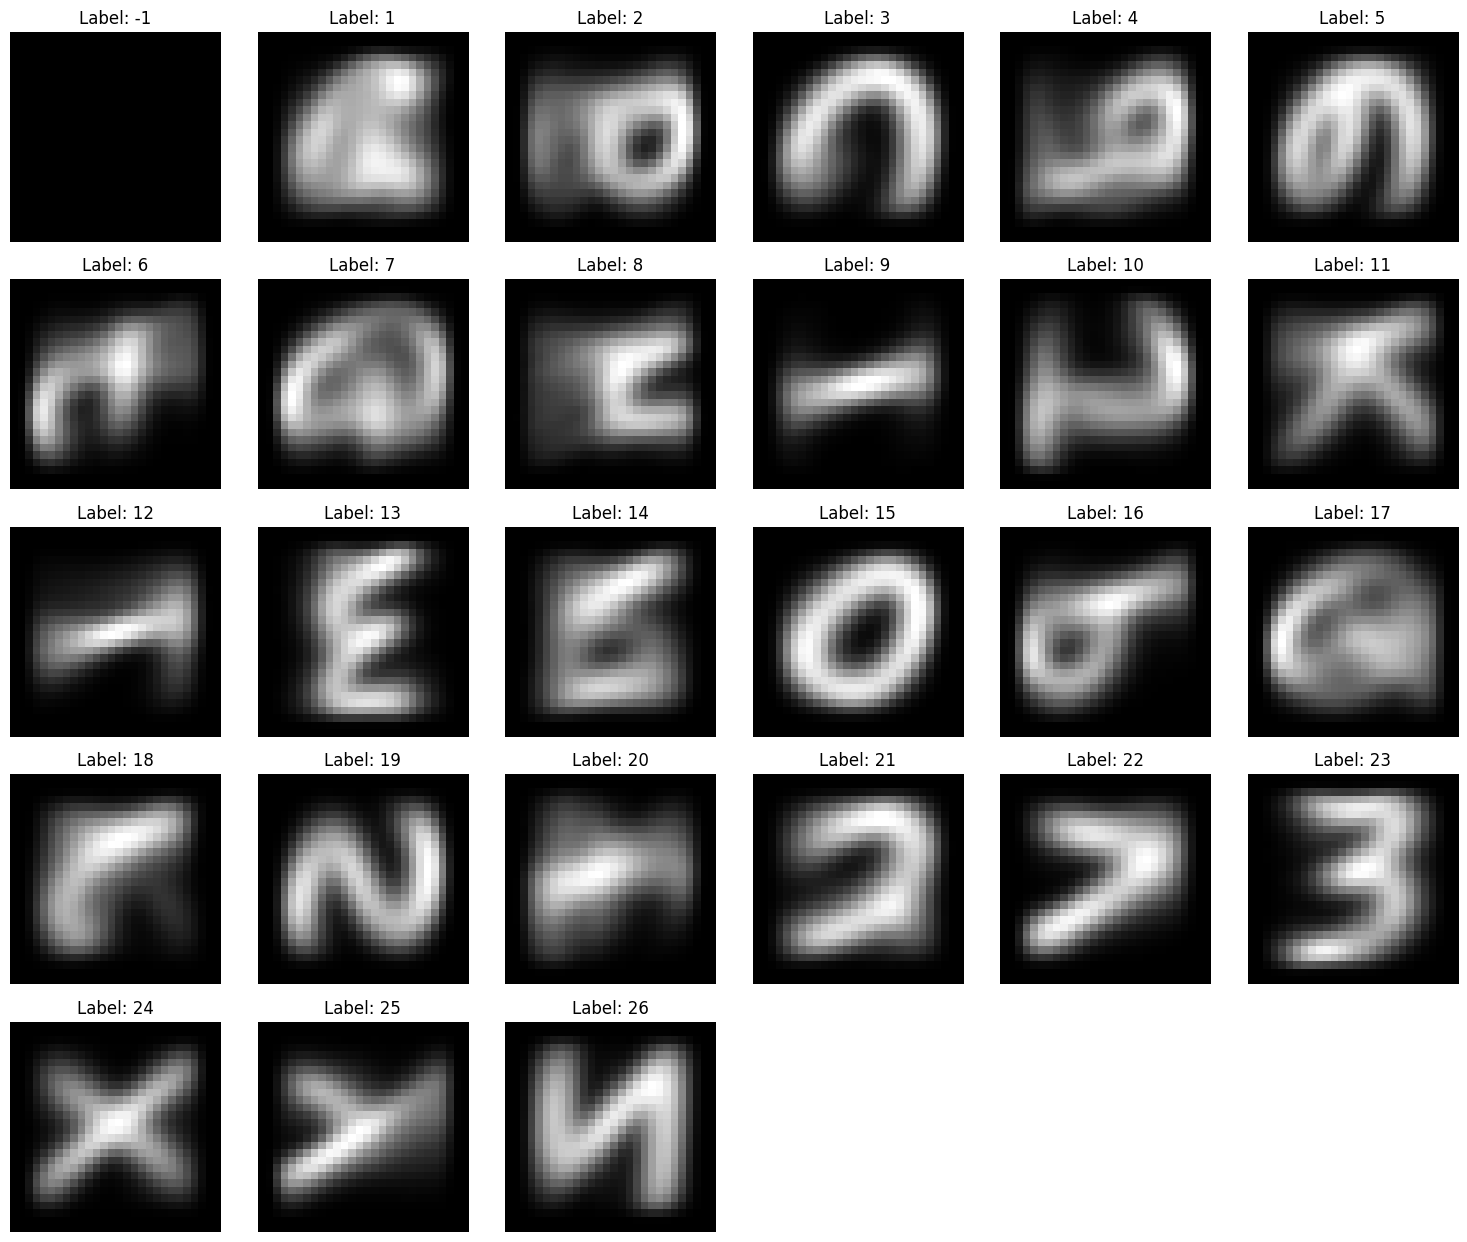

In [18]:
grouped = df.groupby(df[0])
num_labels = len(grouped)
grid_size = int(np.ceil(np.sqrt(num_labels)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

for (label, group), ax in zip(grouped, axes.flatten()):
    average_image = np.mean(group.iloc[:, 1:].values, axis=0)
    average_image = average_image.reshape(28, 28)
    ax.imshow(average_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {label}')
    
for i in range(num_labels, grid_size * grid_size):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Since the -1 class is Nothing across the 10k Images and is not useful in to generate Alpahbetical Characters we will be removing it from the dataset.

In [19]:
df = df[df[0] != -1]

# Train Test Split into X and y
-   Remapping the Labels from 0 - 26 from 1 - 27.

In [20]:
# Define the mapping dictionary
mapping = {1: 0, 
           2: 1, 
           3: 2, 
           4: 3, 
           5: 4, 
           6: 5, 
           7: 6, 
           8: 7, 
           9: 8, 
           10: 9, 
           11: 10, 
           12: 11, 
           13: 12, 
           14: 13, 
           15: 14, 
           16: 15, 
           17: 16, 
           18: 17, 
           19: 18, 
           20: 19, 
           21: 20, 
           22: 21, 
           23: 22, 
           24: 23, 
           25: 24, 
           26: 25, 
           27: 26}

df[0] = df[0].map(mapping)

C:\Users\p2348935\AppData\Local\Temp\ipykernel_14384\519577675.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Converting the the labels to a Numpy Array and to Categorical, and Converting the X axis to a Numpy Array too, and reshaping the image to 28 by 28 by 1 as we want the images to be in black and white only.

In [21]:
y_pre = np.array(df.iloc[:,0].values)
y_pre = pd.Categorical(y_pre)

X = np.array(df.iloc[:,1:].values)
X = X.reshape(-1,28,28,1)

# Preprocessing the images to correct the oreintation.
-   Rotating the Image by 90.
-   Verticaly Flipping the Images. 
-   Converting the numbers from 0 - 255 to -1 to 1.

In [22]:
preprocessed = []
for image in X:
    rotated_image = rotate(image, 90, reshape=False)
    flipped_image = np.flipud(rotated_image)
    preprocessed.append(flipped_image)
X_pre = np.array(preprocessed)
X = X_pre

In [23]:
X = X.astype('float32')
X_pre = (X - 127.5) / 127.5

In [24]:
print(f'y_pre Uniqie : {y_pre.unique()}')
print(f'y_pre Shape : {y_pre.shape}')
print(f'X_pre Shape : {X_pre.shape}')

y_pre Uniqie : [22, 6, 15, 14, 16, ..., 19, 8, 5, 11, 0]
Length: 26
Categories (26, int64): [0, 1, 2, 3, ..., 22, 23, 24, 25]
y_pre Shape : (88800,)
X_pre Shape : (88800, 28, 28, 1)


# Utility Functions
- Saving Images into Directory

In [ ]:
def save_imgs(self, epoch, Dir_Name, File_Name):
    r, c = 10, 10
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs = self.generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    os.makedirs(f'{Dir_Name}', exist_ok=True)
    fig.savefig(f"{Dir_Name}/{File_Name}_{epoch}.png")
    plt.close()

In [ ]:
def Learning_Curve(Model):
    cond_gan_hist_df = pd.DataFrame(Model.history)

    # using pandas dataframe to plot out learning curve
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), tight_layout=True)
    cond_gan_hist_df.loc[:, ["d_loss", 'g_loss']].plot(
        ax=ax1, title=r'Learning Curve of Loss Function CE')
    cond_gan_hist_df.loc[:, ['D(x|y)', 'D(G(z|y))']].plot(
        ax=ax2, title=r'Learning Curve of Discriminator')
    cond_gan_hist_df.loc[:, 'KL Divergence'].plot(
        ax=ax3, title=r'Learning Curve of Probabilistic Similarity')
    plt.show()

In [21]:
# Initialize an empty DataFrame
Model_Results = pd.DataFrame()

# Assuming baseModelHistory is a dictionary with history data
def Update_Models(History,Name,Batch_size):
    global Model_Results
    History = History.history

    print(History)
    
    # Find the index of the best validation accuracy
    best_val_idx = np.argmax(History["val_accuracy"])

    # Result dictionary for the best epoch
    result = {
        'Model Name': Name,
        'epoch': len(History["loss"]),
        'Batch Size': Batch_size,
        'best_val_accuracy': History["val_accuracy"][best_val_idx],
        'best_val_loss': History["val_loss"][best_val_idx],
        'accuracy': History["accuracy"][best_val_idx],
        'loss': History["loss"][best_val_idx]
    }

    # Convert the result dictionary to a DataFrame and append it
    result_df = pd.DataFrame([result])
    Model_Results = pd.concat([Model_Results, result_df], ignore_index=True)

# BaseLine Model
-   Learning Rate : 0.0002
-   Generator Block : 2 Convultional Blocks - 128,64
-   Discriminator Block : 4 Convultional Blocks - 32,64,128,256 

In [22]:
class DCGAN():
    def __init__(self, rows, cols, channels, z = 10):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs=200, batch_size=512, save_interval=1):

        # Load the dataset
        X_train = X_pre

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        batches_per_epoch = X_train.shape[0] // batch_size

        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                # Select a random half of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                # Sample noise and generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator (wants discriminator to mistake images as real)
                g_loss = self.combined.train_on_batch(noise, valid)

                # Plot the progress
                print("Epoch: %d/%d  Batch Size: %d/%d [loss: %f, acc.: %.2f%%] [G loss: %f]" % (
                epoch, epochs, batch, batches_per_epoch, d_loss[0], 100 * d_loss[1], g_loss))

                # If at save interval => save generated image samples
                if epoch % save_interval == 0:
                    save_imgs(self,epoch,'DCGAN Base Line','DCGAN')

In [23]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=200, batch_size=1024, save_interval=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 64)         256       
 ormalization)                                          

# CGAN Model - Using Labels
-   Learning Rate : 0.0002
-   Generator Block : 2 Convultional Blocks - 128,128
-   Discriminator Block : 2 Convultional Blocks - 64,64

In [21]:
class CGAN():
    def __init__(self, rows, cols, channels, z=100, num_classes=26):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        self.num_classes = num_classes
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.define_discriminator(self.img_shape, self.num_classes)
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        self.generator = self.define_generator(self.latent_dim, self.num_classes)
        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([z, label])
        self.discriminator.trainable = False
        valid = self.discriminator([img, label])
        self.combined = Model([z, label], valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def define_discriminator(self, in_shape, n_classes):
        in_label = Input(shape=(1,))
        li = Embedding(n_classes, 50)(in_label)
        n_nodes = in_shape[0] * in_shape[1]
        li = Dense(n_nodes)(li)
        li = Reshape((in_shape[0], in_shape[1], 1))(li)
        in_image = Input(shape=in_shape)
        merge = Concatenate()([in_image, li])
        fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merge)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Flatten()(fe)
        fe = Dropout(0.4)(fe)
        out_layer = Dense(1, activation='sigmoid')(fe)
        model = Model([in_image, in_label], out_layer)
        return model

    def define_generator(self, latent_dim, n_classes):
        in_label = Input(shape=(1,))
        li = Embedding(n_classes, 50)(in_label)
        n_nodes = 7 * 7
        li = Dense(n_nodes)(li)
        li = Reshape((7, 7, 1))(li)
        in_lat = Input(shape=(latent_dim,))
        n_nodes = 128 * 7 * 7
        gen = Dense(n_nodes)(in_lat)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Reshape((7, 7, 128))(gen) 
        merge = Concatenate()([gen, li])
        gen = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(merge)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        out_layer = Conv2D(1, (7, 7), activation='tanh', padding='same')(gen)
        model = Model([in_lat, in_label], out_layer)
        return model

    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.arange(0, r * c).reshape(-1, 1) % self.num_classes  # Ensure labels are within valid range
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.suptitle(f"CGAN (Epoch {epoch})", fontsize=16)
        os.makedirs('CGAN', exist_ok=True)
        fig.savefig("CGAN/CGAN_%d.png" % epoch)
        plt.close()


    def train(self, epochs=200, batch_size=1024, save_interval=1, gen_steps=3):
        X_train = X_pre
        y_train = y_pre

        batches_per_epoch = X_train.shape[0] // batch_size

        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                labels_real = np.ones((batch_size, 1))  # Real labels

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_labels = np.random.randint(0, self.num_classes, (batch_size, 1))  # Ensure valid range
                gen_imgs = self.generator.predict([noise, gen_labels])
                labels_fake = np.zeros((batch_size, 1))  # Fake labels

                d_loss_real = self.discriminator.train_on_batch([imgs, y_train[idx]], labels_real)
                d_loss_fake = self.discriminator.train_on_batch([gen_imgs, gen_labels], labels_fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                g_loss = None
                for _ in range(gen_steps):
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    gen_labels = np.random.randint(0, self.num_classes, (batch_size, 1))  # Ensure valid range
                    valid_y = np.ones((batch_size, 1))
                    g_loss = self.combined.train_on_batch([noise, gen_labels], valid_y)

                # Print the progress
                print(f"Epoch {epoch + 1}/{epochs}, Batch {batch + 1}/{batches_per_epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}]")

            if (epoch) % save_interval == 0:
                self.save_imgs(epoch + 1)

In [22]:
img_rows, img_cols, channels = 28, 28, 1

# Instantiate and train the CGAN
cgan = CGAN(img_rows, img_cols, channels)
cgan.train()

32/32 [==============================] - 4s 3ms/step
Epoch 1/200, Batch 1/86 [D loss: 0.709317535161972, acc.: 14.50%] [G loss: 0.6897342801094055]
32/32 [==============================] - 0s 5ms/step
Epoch 1/200, Batch 2/86 [D loss: 0.6748547255992889, acc.: 45.07%] [G loss: 0.6760390400886536]
32/32 [==============================] - 0s 8ms/step
Epoch 1/200, Batch 3/86 [D loss: 0.6501210927963257, acc.: 50.00%] [G loss: 0.6345533132553101]
32/32 [==============================] - 0s 3ms/step
Epoch 1/200, Batch 4/86 [D loss: 0.6504237353801727, acc.: 50.00%] [G loss: 0.5695610642433167]
32/32 [==============================] - 0s 3ms/step
Epoch 1/200, Batch 5/86 [D loss: 0.6728051900863647, acc.: 50.00%] [G loss: 0.5464956760406494]
32/32 [==============================] - 0s 3ms/step
Epoch 1/200, Batch 6/86 [D loss: 0.6592959016561508, acc.: 50.00%] [G loss: 0.5933941006660461]
32/32 [==============================] - 0s 3ms/step
Epoch 1/200, Batch 7/86 [D loss: 0.62067811191082, acc

# ACGAN

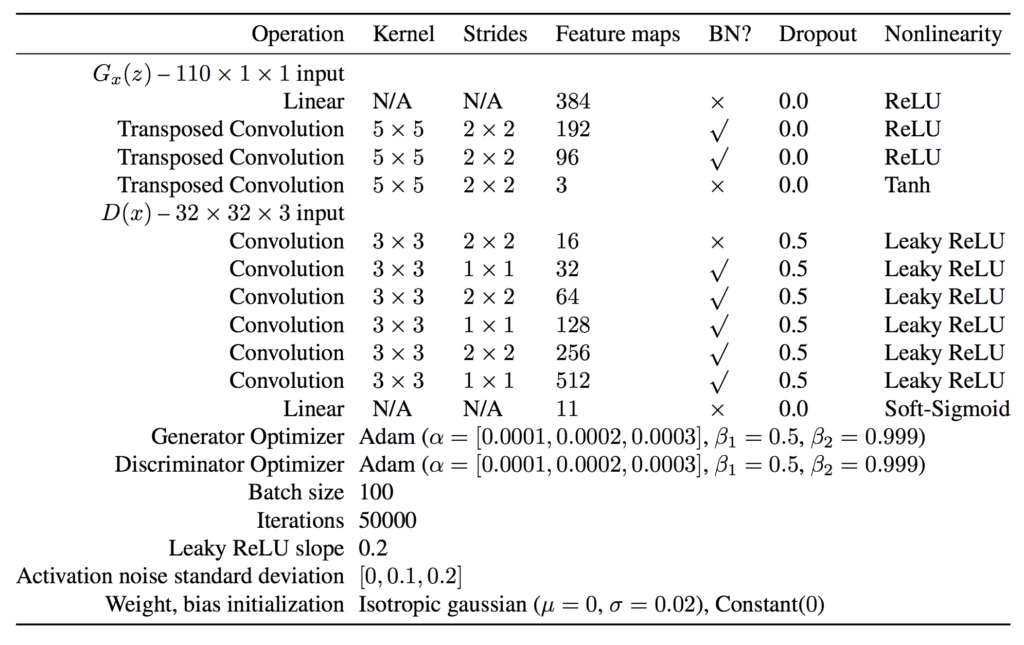

In [2]:
class ACGAN:
    def __init__(self, rows, cols, channels, z=100, num_classes=26):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        self.num_classes = num_classes
        self.discriminator = self.define_discriminator(self.img_shape, self.num_classes)
        self.generator = self.define_generator(self.latent_dim, self.num_classes)
        z = Input(shape=(self.latent_dim,))
        self.discriminator.trainable = False
        self.combined = self.define_gan(self.generator, self.discriminator)

    def define_discriminator(self, in_shape, n_classes):
        init = RandomNormal(stddev=0.02)
        in_image = Input(shape=in_shape)
        fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Flatten()(fe)
        out1 = Dense(1, activation='sigmoid')(fe)
        out2 = Dense(n_classes, activation='softmax')(fe)
        model = Model(in_image, [out1, out2])
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
        return model

    def define_generator(self, latent_dim, n_classes):
        init = RandomNormal(stddev=0.02)
        in_label = Input(shape=(1,))
        li = Embedding(n_classes, 50)(in_label)
        n_nodes = 7 * 7
        li = Dense(n_nodes, kernel_initializer=init)(li)
        li = Reshape((7, 7, 1))(li)
        in_lat = Input(shape=(latent_dim,))
        n_nodes = 256 * 7 * 7
        gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
        gen = Activation('relu')(gen)
        gen = Reshape((7, 7, 256))(gen)
        merge = Concatenate()([gen, li])
        gen = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
        gen = BatchNormalization()(gen)
        gen = Activation('relu')(gen)
        gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
        out_layer = Activation('tanh')(gen)
        model = Model([in_lat, in_label], out_layer)
        return model

    def define_gan(self, g_model, d_model):
        for layer in d_model.layers:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = False

        gan_output = d_model(g_model.output)
        model = Model(g_model.input, gan_output)
        opt = Adam(lr=0.00012, beta_1=0.5)
        model.summary()
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
        return model

    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.arange(0, r * c).reshape(-1, 1) % self.num_classes
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.suptitle(f"ACGAN (Epoch {epoch})", fontsize=16)
        os.makedirs('ACGAN', exist_ok=True)
        fig.savefig(f"ACGAN/ACGAN_mnist_{epoch}.png")
        plt.close()

    def generate_latent_points(self, latent_dim, n_samples, n_classes=26):
        x_input = randn(latent_dim * n_samples)
        z_input = x_input.reshape(n_samples, latent_dim)
        labels = randint(0, n_classes, n_samples)
        return [z_input, labels]

    def train(self, epochs=100, batch_size=1024, save_interval=1, gen_steps=2):
        X_train = X_pre
        y_train = y_pre

        batches_per_epoch = X_train.shape[0] // batch_size

        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                labels_real = np.ones((batch_size, 1))

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_labels = np.random.randint(0, self.num_classes, (batch_size, 1))
                gen_imgs = self.generator.predict([noise, gen_labels])
                labels_fake = np.zeros((batch_size, 1))

                d_loss_real = self.discriminator.train_on_batch(imgs, [labels_real, y_train[idx]])
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [labels_fake, gen_labels])
                d_loss_1 = 0.5 * np.add(d_loss_real[0], d_loss_fake[0])
                d_loss_2 = 0.5 * np.add(d_loss_real[1], d_loss_fake[1])
                for _ in range(gen_steps):
                    z_input, z_labels = self.generate_latent_points(self.latent_dim, batch_size)
                    y_gan = np.ones((batch_size, 1))
                    g_loss = self.combined.train_on_batch([z_input, z_labels], [y_gan, z_labels])

                print(f"Epoch {epoch + 1}/{epochs}, Batch {batch + 1}/{batches_per_epoch} [D loss 1: {d_loss_1}, D loss 2: {d_loss_2}, G loss: {g_loss}]")

            if epoch % save_interval == 0:
                self.save_imgs(epoch + 1)

In [3]:
# Set image dimensions
img_rows, img_cols, channels = 28, 28, 1

# Instantiate and train the DCGAN
acgan5 = ACGAN(img_rows, img_cols, channels)
acgan5.train()

c:\Users\p2348935\.conda\envs\gpu_env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
c:\Users\p2348935\.conda\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 12544)        1266944     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        1300        ['input_2[0][0]']                
                                                                                            

NameError: name 'X_pre' is not defined

In [29]:
class ACGAN:
    def __init__(self, rows, cols, channels, z=100, num_classes=26):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        self.num_classes = num_classes
        self.discriminator = self.define_discriminator(self.img_shape, self.num_classes)
        self.generator = self.define_generator(self.latent_dim, self.num_classes)
        z = Input(shape=(self.latent_dim,))
        self.discriminator.trainable = False
        self.combined = self.define_gan(self.generator, self.discriminator)

    def define_discriminator(self, in_shape, n_classes):
        init = RandomNormal(stddev=0.02)
        in_image = Input(shape=in_shape)
        fe = Conv2D(16, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(32, (3,3), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(128, (3,3), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Flatten()(fe)
        out1 = Dense(1, activation='sigmoid')(fe)
        out2 = Dense(n_classes, activation='softmax')(fe)
        model = Model(in_image, [out1, out2])
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
        return model

    def define_generator(self, latent_dim, n_classes):
        init = RandomNormal(stddev=0.02)
        in_label = Input(shape=(1,))
        li = Embedding(n_classes, 50)(in_label)
        n_nodes = 7 * 7
        li = Dense(n_nodes, kernel_initializer=init)(li)
        li = Reshape((7, 7, 1))(li)
        in_lat = Input(shape=(latent_dim,))
        n_nodes = 256 * 7 * 7
        gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
        gen = Activation('relu')(gen)
        gen = Reshape((7, 7, 256))(gen)
        merge = Concatenate()([gen, li])
        gen = Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', kernel_initializer=init)(merge)
        gen = BatchNormalization()(gen)
        gen = Activation('relu')(gen)
        gen = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
        gen = BatchNormalization()(gen)
        gen = Activation('relu')(gen)
        gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
        out_layer = Activation('tanh')(gen)
        model = Model([in_lat, in_label], out_layer)
        return model

    def define_gan(self, g_model, d_model):
        for layer in d_model.layers:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = False

        gan_output = d_model(g_model.output)
        model = Model(g_model.input, gan_output)
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.summary()
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
        return model

    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.arange(0, r * c).reshape(-1, 1) % self.num_classes
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.suptitle(f"ACGAN (Epoch {epoch})", fontsize=16)
        os.makedirs('ACGAN 2', exist_ok=True)
        fig.savefig(f"ACGAN 2/ACGAN_mnist_{epoch}.png")
        plt.close()

    def generate_latent_points(self, latent_dim, n_samples, n_classes=26):
        x_input = randn(latent_dim * n_samples)
        z_input = x_input.reshape(n_samples, latent_dim)
        labels = randint(0, n_classes, n_samples)
        return [z_input, labels]

    def train(self, epochs=100, batch_size=1024, save_interval=1, gen_steps=2):
        X_train = X_pre
        y_train = y_pre

        batches_per_epoch = X_train.shape[0] // batch_size

        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                labels_real = np.ones((batch_size, 1))

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_labels = np.random.randint(0, self.num_classes, (batch_size, 1))
                gen_imgs = self.generator.predict([noise, gen_labels])
                labels_fake = np.zeros((batch_size, 1))

                d_loss_real = self.discriminator.train_on_batch(imgs, [labels_real, y_train[idx]])
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [labels_fake, gen_labels])
                d_loss_1 = 0.5 * np.add(d_loss_real[0], d_loss_fake[0])
                d_loss_2 = 0.5 * np.add(d_loss_real[1], d_loss_fake[1])
                for _ in range(gen_steps):
                    z_input, z_labels = self.generate_latent_points(self.latent_dim, batch_size)
                    y_gan = np.ones((batch_size, 1))
                    g_loss = self.combined.train_on_batch([z_input, z_labels], [y_gan, z_labels])

                print(f"Epoch {epoch + 1}/{epochs}, Batch {batch + 1}/{batches_per_epoch} [D loss 1: {d_loss_1}, D loss 2: {d_loss_2}, G loss: {g_loss}]")

            if epoch % save_interval == 0:
                self.save_imgs(epoch + 1)

In [30]:
# Set image dimensions
img_rows, img_cols, channels = 28, 28, 1

# Instantiate and train the DCGAN
acgan7 = ACGAN(img_rows, img_cols, channels)
acgan7.train()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 12544)        1266944     ['input_15[0][0]']               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 50)        1300        ['input_14[0][0]']               
                                                                                           

: 

: 